Testing changes to haltere inspired weights.

In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from estimator import classical_weights

In [2]:
def haltere_covariance_matrix(N, lowcut, highcut, decay_coef, scale=1):
    '''
    Generates the (N x N) covariance matrix for Gaussain Process inspired by the STAs 
    of mechanosensory neurons in insect halteres.
    
    $$k(t, t') = \mathbb{E}[w(t)^T w(t')] =  \sum_{j=0}^{N-1} \lambda_j \cos{\dfrac{i 2 \pi j (t-t')}{N}} * exp((- \|t- N - 1\|^2 + \|t'- N - 1\|^2) / a ** 2) $$
    $$ \lambda_j = \begin{cases} 1 & lowcut \leq highcut \\ 0 & otherwise \end{cases}$$

    Parameters
    ----------

    N: int
        Number of features
    
    lowcut: int
        low end of the frequency band filter

    highcut : int
        high end of the frequency band filter
        
    decay_coef : float
        controls the how fast the random features decay
    
    Returns
    -------
    C : array-like of shape (N, N) 
        Covariance matrix
    '''
    
    lamda = np.zeros(N)
    lamda[lowcut:highcut] = 1

    grid = np.arange(0, N)
    yy, xx = np.meshgrid(grid, grid)
    diff = xx - yy

    # sinusoidal part
    C_cos = np.zeros((N, N))
    for j in range(N):
        C_cos += lamda[j] * np.cos(2 * np.pi * j * diff / N)

    # exponential part
    C_exp = np.exp((-(xx - N) ** 2 - (yy - N) ** 2) / decay_coef ** 2)

    # final covariance matrix
    C = C_cos * C_exp 
    C *= (scale * N / np.trace(C))
    C += 1e-5 * np.eye(N)
    return C

def haltere_inspired_weights(M, N, lowcut, highcut, decay_coef, scale=1, random_state=None):
    """
    Generates random weights with tuning similar to mechanosensory 
    neurons in insect halteres. Weights are band-limited gaussian 
    process with fourier eigenbasis.

    Parameters
    ----------

    M : int
        Number of random weights

    N : int
        Number of features

    lowcut: int
        Low end of the frequency band. 

    highcut: int
        High end of the frequency band.
        
    decay_coef : float
        controls the how fast the random features decay
    
    random_state : int, default=None
        Used to set the seed when generating random weights.
    
    Returns
    -------

    W : array-like of shape (M, N)
        Random weights.
    """
    np.random.seed(random_state)
    C = haltere_covariance_matrix(N, lowcut, highcut, decay_coef, scale)
    L = la.cholesky(C)
    W = np.dot(L, np.random.randn(N, M)).T
    return W

## plotting all covariance matrices

In [3]:
N, lowcut, highcut, decay_coef, scale = 150, 3, 8, 30, 1

In [4]:
lamda = np.zeros(N)
lamda[lowcut:highcut] = 1

grid = np.arange(0, N)
yy, xx = np.meshgrid(grid, grid)
diff = xx - yy

# sinusoidal part
C_cos = np.zeros((N, N))
for j in range(N):
    C_cos += lamda[j] * np.cos(2 * np.pi * j * diff / N)

# exponential part
C_exp = np.exp((-(xx - N) ** 2 - (yy - N) ** 2) / decay_coef ** 2)

# final covariance matrix
C = C_cos * C_exp 
C *= (scale * N / np.trace(C))
C += 1e-5 * np.eye(N)

(-0.5, 149.5, 149.5, -0.5)

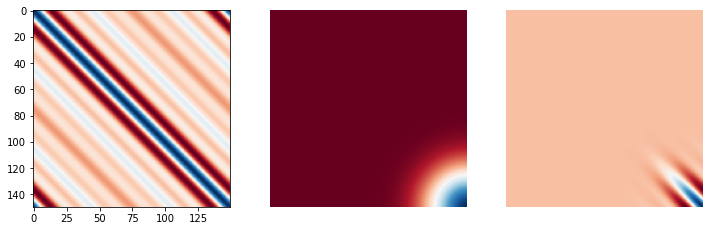

In [6]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(131)
plt.imshow(C_cos, cmap='RdBu')

ax = fig.add_subplot(132)
plt.imshow(C_exp, cmap='RdBu')
plt.axis('off')

ax = fig.add_subplot(133)
plt.imshow(C, cmap='RdBu')
plt.axis('off')
# plt.colorbar()

## testing new covariance functions

11.460446722465086


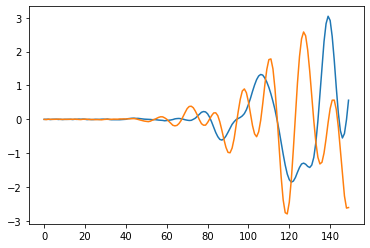

In [7]:
W = haltere_inspired_weights(100, 150, 3, 13, decay_coef=50)
print(np.mean(la.norm(W, axis=1)))

fig = plt.figure()
for i in range(2):
    plt.plot(W[i])

## test on tasks

In [12]:
from data_fns import frequency_detection
from sklearn.model_selection import train_test_split
from estimator import RFClassifier, relu
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier

# load data
n_samples, fs, signal_duration, k, a = 5000, 1500, 0.1, 5, 0.8
X, y = frequency_detection(n_samples, fs, k, signal_duration, a, random_state=20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
b = np.mean(la.norm(X_train, axis=1) ** 2 / X_train.shape[1])

In [13]:
sgd = SGDClassifier(loss="squared_hinge", alpha=1, max_iter=200, tol=1e-5, shuffle=True,
                    learning_rate="optimal", early_stopping=True, validation_fraction=0.1, n_iter_no_change=20)
svc = LinearSVC(random_state=20, tol=1e-4, max_iter=200)

n_features = sorted(set(np.logspace(0, 2.5, 50).astype('int')))

kwargs = {'lowcut': 3, 'highcut': 6, 'decay_coef': 50}
params_neural = {'weight_fun': haltere_inspired_weights, 'kwargs': kwargs, 'bias': b, 'nonlinearity': relu, 'clf': sgd}
params_classical = {'weight_fun': classical_weights, 'bias': b, 'nonlinearity': relu, 'clf': sgd}

accuracy = {'classical': [], 'halteres': []}
for i, m in enumerate(n_features):
    # neural
    clf = RFClassifier(m, **params_neural)
    clf.fit(X_train, y_train)
    test_err = clf.score(X_test, y_test)
    accuracy['halteres'].append(1 - test_err)
    
    # classical
    clf = RFClassifier(m, **params_classical)
    clf.fit(X_train, y_train)
    test_err = clf.score(X_test, y_test)
    accuracy['classical'].append(1 - test_err)
    
    print('Iter: %d/%d' % (i, len(n_features)))

Iter: 0/39
Iter: 1/39
Iter: 2/39
Iter: 3/39
Iter: 4/39
Iter: 5/39
Iter: 6/39
Iter: 7/39
Iter: 8/39
Iter: 9/39
Iter: 10/39
Iter: 11/39
Iter: 12/39
Iter: 13/39
Iter: 14/39
Iter: 15/39
Iter: 16/39
Iter: 17/39
Iter: 18/39
Iter: 19/39
Iter: 20/39
Iter: 21/39
Iter: 22/39
Iter: 23/39
Iter: 24/39
Iter: 25/39
Iter: 26/39
Iter: 27/39
Iter: 28/39
Iter: 29/39
Iter: 30/39
Iter: 31/39
Iter: 32/39
Iter: 33/39
Iter: 34/39
Iter: 35/39
Iter: 36/39
Iter: 37/39
Iter: 38/39


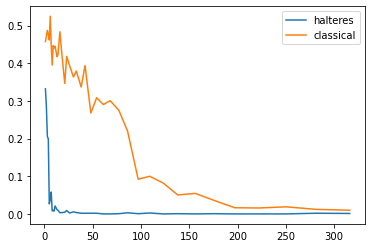

In [14]:
fig = plt.figure()
plt.plot(n_features, accuracy['halteres'], label='halteres')
plt.plot(n_features, accuracy['classical'], label='classical')
plt.legend()

## Frequency XOR

In [15]:
from data_fns import frequency_XOR
from sklearn.model_selection import train_test_split
from estimator import RFClassifier, relu
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier

# load data
n_samples, fs, signal_duration, k1, k2, a = 5000, 1500, 0.1, 5, 8, 0.99
X, y = frequency_XOR(n_samples, fs, k1, k2, signal_duration, a, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
b = np.mean(la.norm(X_train, axis=1) ** 2 / X_train.shape[1])

In [16]:
sgd = SGDClassifier(loss="squared_hinge", alpha=1, max_iter=200, tol=1e-5, shuffle=True,
                    learning_rate="optimal", early_stopping=True, validation_fraction=0.1, n_iter_no_change=20)
# svc = LinearSVC(random_state=20, tol=1e-4, max_iter=200)

n_features = sorted(set(np.logspace(0, 2.5, 50).astype('int')))

kwargs = {'lowcut': 3, 'highcut': 13, 'decay_coef': 50}
params_neural = {'weight_fun': haltere_inspired_weights, 'kwargs': kwargs, 'bias': b, 'nonlinearity': relu, 'clf': sgd}
params_classical = {'weight_fun': classical_weights, 'bias': b, 'nonlinearity': relu, 'clf': sgd}

accuracy = {'classical': {'mean':[], 'std': []}, 'halteres': {'mean':[], 'std': []}}
for i, m in enumerate(n_features):
    # neural
    err = []
    for t in range(5):
        clf = RFClassifier(m, **params_neural)
        clf.fit(X_train, y_train)
        test_err = clf.score(X_test, y_test)
        err.append(1 - test_err)
    accuracy['halteres']['mean'].append(np.mean(err))
    accuracy['halteres']['std'].append(np.std(err))
    
    # classical
    err = []
    for t in range(5):
        clf = RFClassifier(m, **params_classical)
        clf.fit(X_train, y_train)
        test_err = clf.score(X_test, y_test)
        err.append(1 - test_err)
    accuracy['classical']['mean'].append(np.mean(err))
    accuracy['classical']['std'].append(np.std(err))
    
    print('Iter: %d/%d' % (i, len(n_features)))

Iter: 0/39
Iter: 1/39
Iter: 2/39
Iter: 3/39
Iter: 4/39
Iter: 5/39
Iter: 6/39
Iter: 7/39
Iter: 8/39
Iter: 9/39
Iter: 10/39
Iter: 11/39
Iter: 12/39
Iter: 13/39
Iter: 14/39
Iter: 15/39
Iter: 16/39
Iter: 17/39
Iter: 18/39
Iter: 19/39
Iter: 20/39
Iter: 21/39
Iter: 22/39
Iter: 23/39
Iter: 24/39
Iter: 25/39
Iter: 26/39
Iter: 27/39
Iter: 28/39
Iter: 29/39
Iter: 30/39
Iter: 31/39
Iter: 32/39
Iter: 33/39
Iter: 34/39
Iter: 35/39
Iter: 36/39
Iter: 37/39
Iter: 38/39


In [17]:
import pickle
with open('results/freq_XOR/freq_XOR.pickle', 'rb') as handle:
    results = pickle.load(handle)
n_features_old = sorted(set(np.logspace(0, 3, 50).astype('int')))

halteres, 0.4000
classical, 19.5600


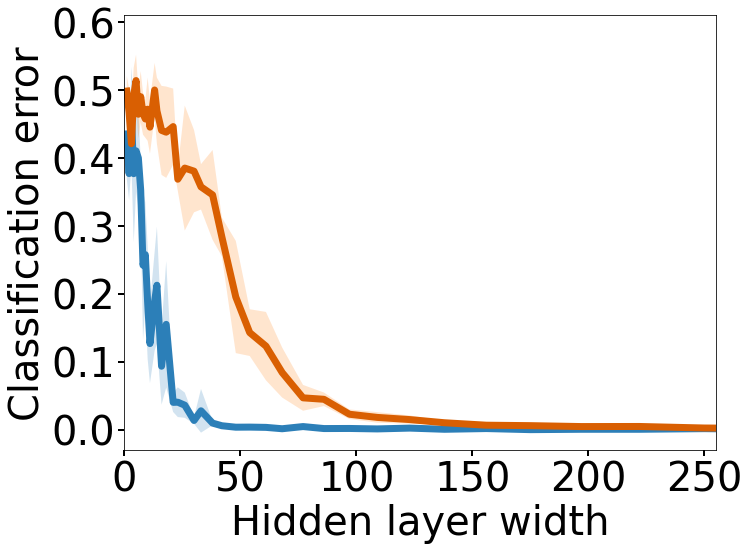

In [18]:
models = ['halteres', 'classical']
labels = {'halteres': 'haltere-inspired', 'classical': 'classical'}
colors = {'halteres': '#2c7fb8', 'classical': '#d95f02'}

fig = plt.figure(figsize=(10.6, 8))
ax = fig.add_subplot(111)
for m in models:
    avg_test_err = np.array(accuracy[m]['mean'])
    std_test_err = np.array(accuracy[m]['std'])
    plt.plot(n_features, avg_test_err, label=labels[m], lw=7, c=colors[m])
    plt.fill_between(n_features, avg_test_err - std_test_err, avg_test_err + std_test_err, alpha=0.2)
    print('%s, %0.4f' % (m, avg_test_err[22] * 100))
    
ax.set_xlim([0, 255])
plt.yticks(np.arange(0, 0.7, 0.1))
plt.ylim([-0.03, 0.61])
# ax.set_yscale('log')
plt.xlabel('Hidden layer width', fontsize=40)
plt.ylabel('Classification error', fontsize=40)
plt.xticks(np.arange(0, 255, 50))
ax.tick_params(axis = 'both', which = 'major', labelsize = 40, width=2, length=6)